In [48]:
# This is used to read fits files 
from astropy.io import fits

# Useful for a bunch of stuff
import numpy as np

# Used for Log plots
from matplotlib.colors import LogNorm

# Prettier plots
import seaborn as sns

# Used for median filter to handle noise
from scipy import ndimage

# Used for Gaussian 2D fitting
from scipy import optimize

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib.pyplot as plt 
%matplotlib inline 
%config InlineBackend.figure_formats = ('png', 'retina')

In [49]:
def extract_FITS(filename):
    '''
       Extracts the data cube from the FITS file.
       
       Arguments: 
           filename : name of the file including path
           
       Return variables:
           hdu_list : hdu_list[0].data contains the data cube array in order of wavelength, y, x
           Min      : the starting wavelength value in the cube in Angstroms
           Max      : the ending wavelength value in the cube in Angstroms
           Step     : the step size of the wavelength
           xlen     : the size of the horizontal axis of FOV in arcseconds
           ylen     : the size of the horizontal axis of FOV in arcseconds
    '''
    
    hdu_list = fits.open(filename)
    image, header = fits.getdata(filename, header=True)
    Min = header['CRVAL3']
    step = header['CD3_3']
    Max = Min +  (np.shape(image)[0] - 1) * step
    ypixel = len(hdu_list[0].data[0])
    xpixel = len(hdu_list[0].data[0][0])
    xlen = (header['CD1_1']**2 + header['CD2_1']**2)**(0.5) * xpixel * 3600
    ylen = (header['CD1_2']**2 + header['CD2_2']**2)**(0.5) * ypixel * 3600
    return hdu_list, Min, Max, step, xlen, ylen


def vel2pix(vel):
    '''
       Converts a given velocity value into the corresponding pixel of the specified cube.
       
       Arguments:
           vel      : the velocity value 
        
       Return variables: 
           pixel    : the pixel value 
    '''
    
    return int((vel - Min) / step)


def make_sum(start_vel, end_vel, cube):
    '''
       Makes a direct sum of a set of images in a specified wavelength span. 
       
       Arguments:
           start_vel : the starting velocity value  
           end_vel   : the ending velocity value 
           cube      : oi, oii, oiii
        
       Return variables: 
           sum_img   : the summed image
    '''
    
    sum_img = 0
    start = vel2pix(start_vel)
    end = vel2pix(end_vel)
    length = -start + end
    
    if cube == "oi":
        for i in range(length+1):
            sum_img += hdu_list_oi[0].data[start + i]
            
    if cube == "oii":
        for i in range(length+1):
            sum_img += hdu_list_oii[0].data[start + i]
            
    if cube == "oiii":
        for i in range(length+1):
            sum_img += hdu_list_oiii[0].data[start + i]
            
    return sum_img


def plot_sum(sum_img, minpix, maxpix):
    '''
       Plots a summed image.
       
       Arguments:
           sum_img  : the summed image 
           minpix   : the min value of the colorbar 
           maxpix   : the max value of the colorbar
        
       Return variables: 
           none
    '''
    
    plt.imshow(sum_img, cmap='jet', vmin=minpix, vmax=maxpix, extent=[0, xlen, 0, ylen])
    ax = plt.gca();
    ax.set_yticks(np.arange(0, ylen, 2));
    ax.set_xticks(np.arange(0, xlen, 2));
    plt.xlabel('x (\u2033)');
    plt.ylabel('y (\u2033)');
    plt.colorbar()
    

def plot_log(sum_img, minpix, maxpix, tick):
    '''
       Plots a summed image with a log colorbar.
       
       Arguments:
           sum_img  : the summed image 
           minpix   : the min value of the colorbar 
           maxpix   : the max value of the colorbar
           ticks    : (array) set the ticks on the colorbar
        
       Return variables: 
           none
    '''
    
    sum_img_log = np.copy(sum_img)
    for i in range(len(sum_img)):
        for j in range(len(sum_img[0])):
            if sum_img_log[i][j] <= 0:
                sum_img_log[i][j] = 0.01
    plt.imshow(sum_img_log, cmap='jet', vmin=minpix, vmax=maxpix, extent=[0, xlen, 0, ylen], norm=LogNorm())
    ax = plt.gca();
    ax.set_yticks(np.arange(0, ylen, 2));
    ax.set_xticks(np.arange(0, xlen, 2));
    plt.xlabel('x (\u2033)');
    plt.ylabel('y (\u2033)');
    cbar = plt.colorbar(ticks=tick);
    cbar.ax.set_yticklabels(tick);
    
    
def make_bin(start_vel, end_vel, step, cube, minpix, maxpix, cols, size=(10, 50), tick=False):
    '''
       Make multiple plots of summed images given a specified bin and a specified wavelength span. 
       
       Arguments:
           start_vel : the starting velocity value 
           end_vel   : the ending velocity value 
           step      : the binning size of the velocity  
           cube      : oi, oii, oiii
           minpix    : the min value of the colorbar
           maxpix    : the max value of the colorbar
           cols      : the number of columns of images subplotted
           size      : (optional) the size of the images subplotted
           tick      : (optional) enter array of ticks if log colorbar desired  
        
       Return variables: 
           none
    '''
    
    lst = np.arange(start_vel, end_vel+step, step)
    plt.figure(figsize=size)
    if not tick:
        for i, n in enumerate(lst):
            if (i < len(lst) - 1):
                sum_img = make_sum(lst[i], lst[i+1], cube)
                plt.subplot(15, cols, i+1)
                plot_sum(sum_img, minpix, maxpix)
                plt.title('{} $-$ {} ($km/s$)'.format(lst[i], lst[i+1]))
        plt.tight_layout()
        
    else:
        for i, n in enumerate(lst):
            if (i < len(lst) - 1):
                sum_img = make_sum(lst[i], lst[i+1], cube)
                plt.subplot(15, cols, i+1)
                plot_log(sum_img, minpix, maxpix, tick)
                plt.title('{} $-$ {} ($km/s$)'.format(lst[i], lst[i+1]))
        plt.tight_layout()

In [50]:
image_oi  = 'oi_cube.fits'
image_oii  = 'oii_cube.fits'
image_oiii = 'oiii_cube.fits'

hdu_list_oi, Min_oi, Max_oi, step_oi, xlen, ylen = extract_FITS(image_oi)
hdu_list_oii, Min_oii, Max_oii, step_oii, xlen, ylen = extract_FITS(image_oii)
hdu_list_oiii, Min_oiii, Max_oiii, step_oiii, xlen, ylen = extract_FITS(image_oiii)

if (Min_oi == Min_oii) and (Min_oii == Min_oiii):
    print("Cubes are of the same size")
    Min = Min_oi
    Max = Max_oi
    step = step_oi
    
else:
    print("Warning! Cubes are not of the same size")
    

# Update default figure and font size
plt.rcParams["figure.figsize"] = [9, 7]
plt.rcParams.update({'font.size': 13})

Cubes are of the same size


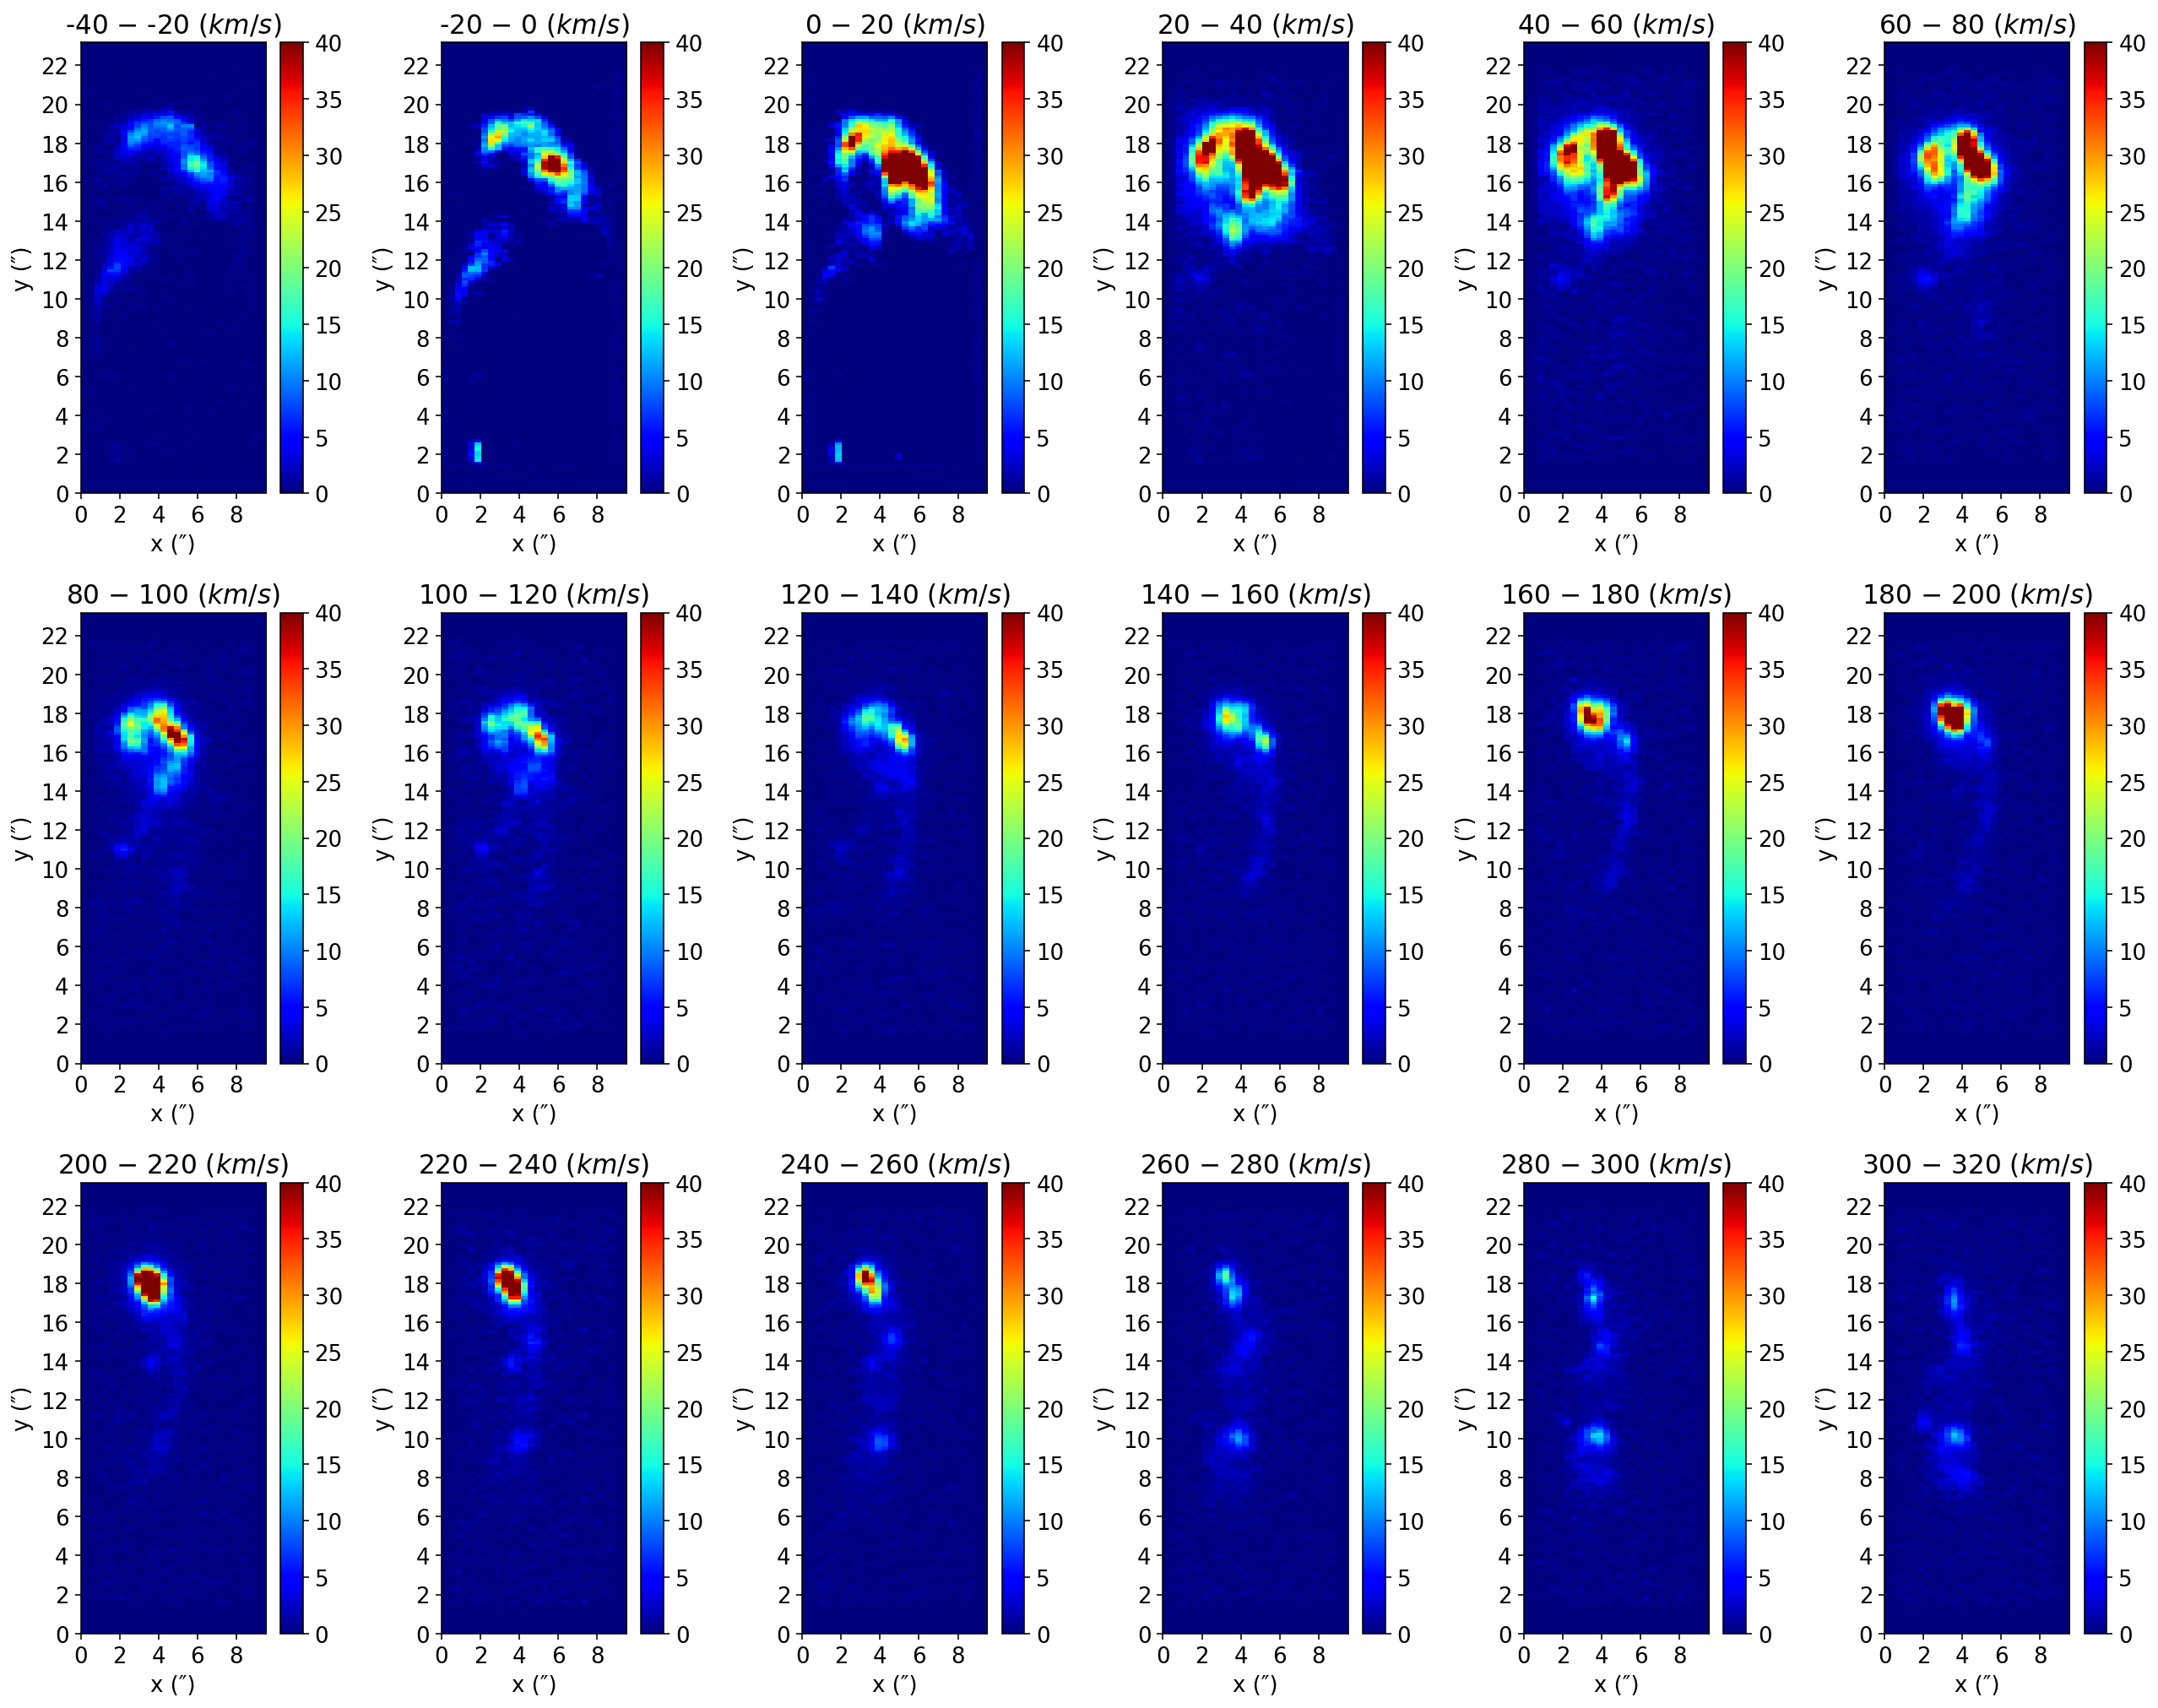

In [60]:
make_bin(-40, 320, 20, "oi", 0, 40, 6, (18, 70))

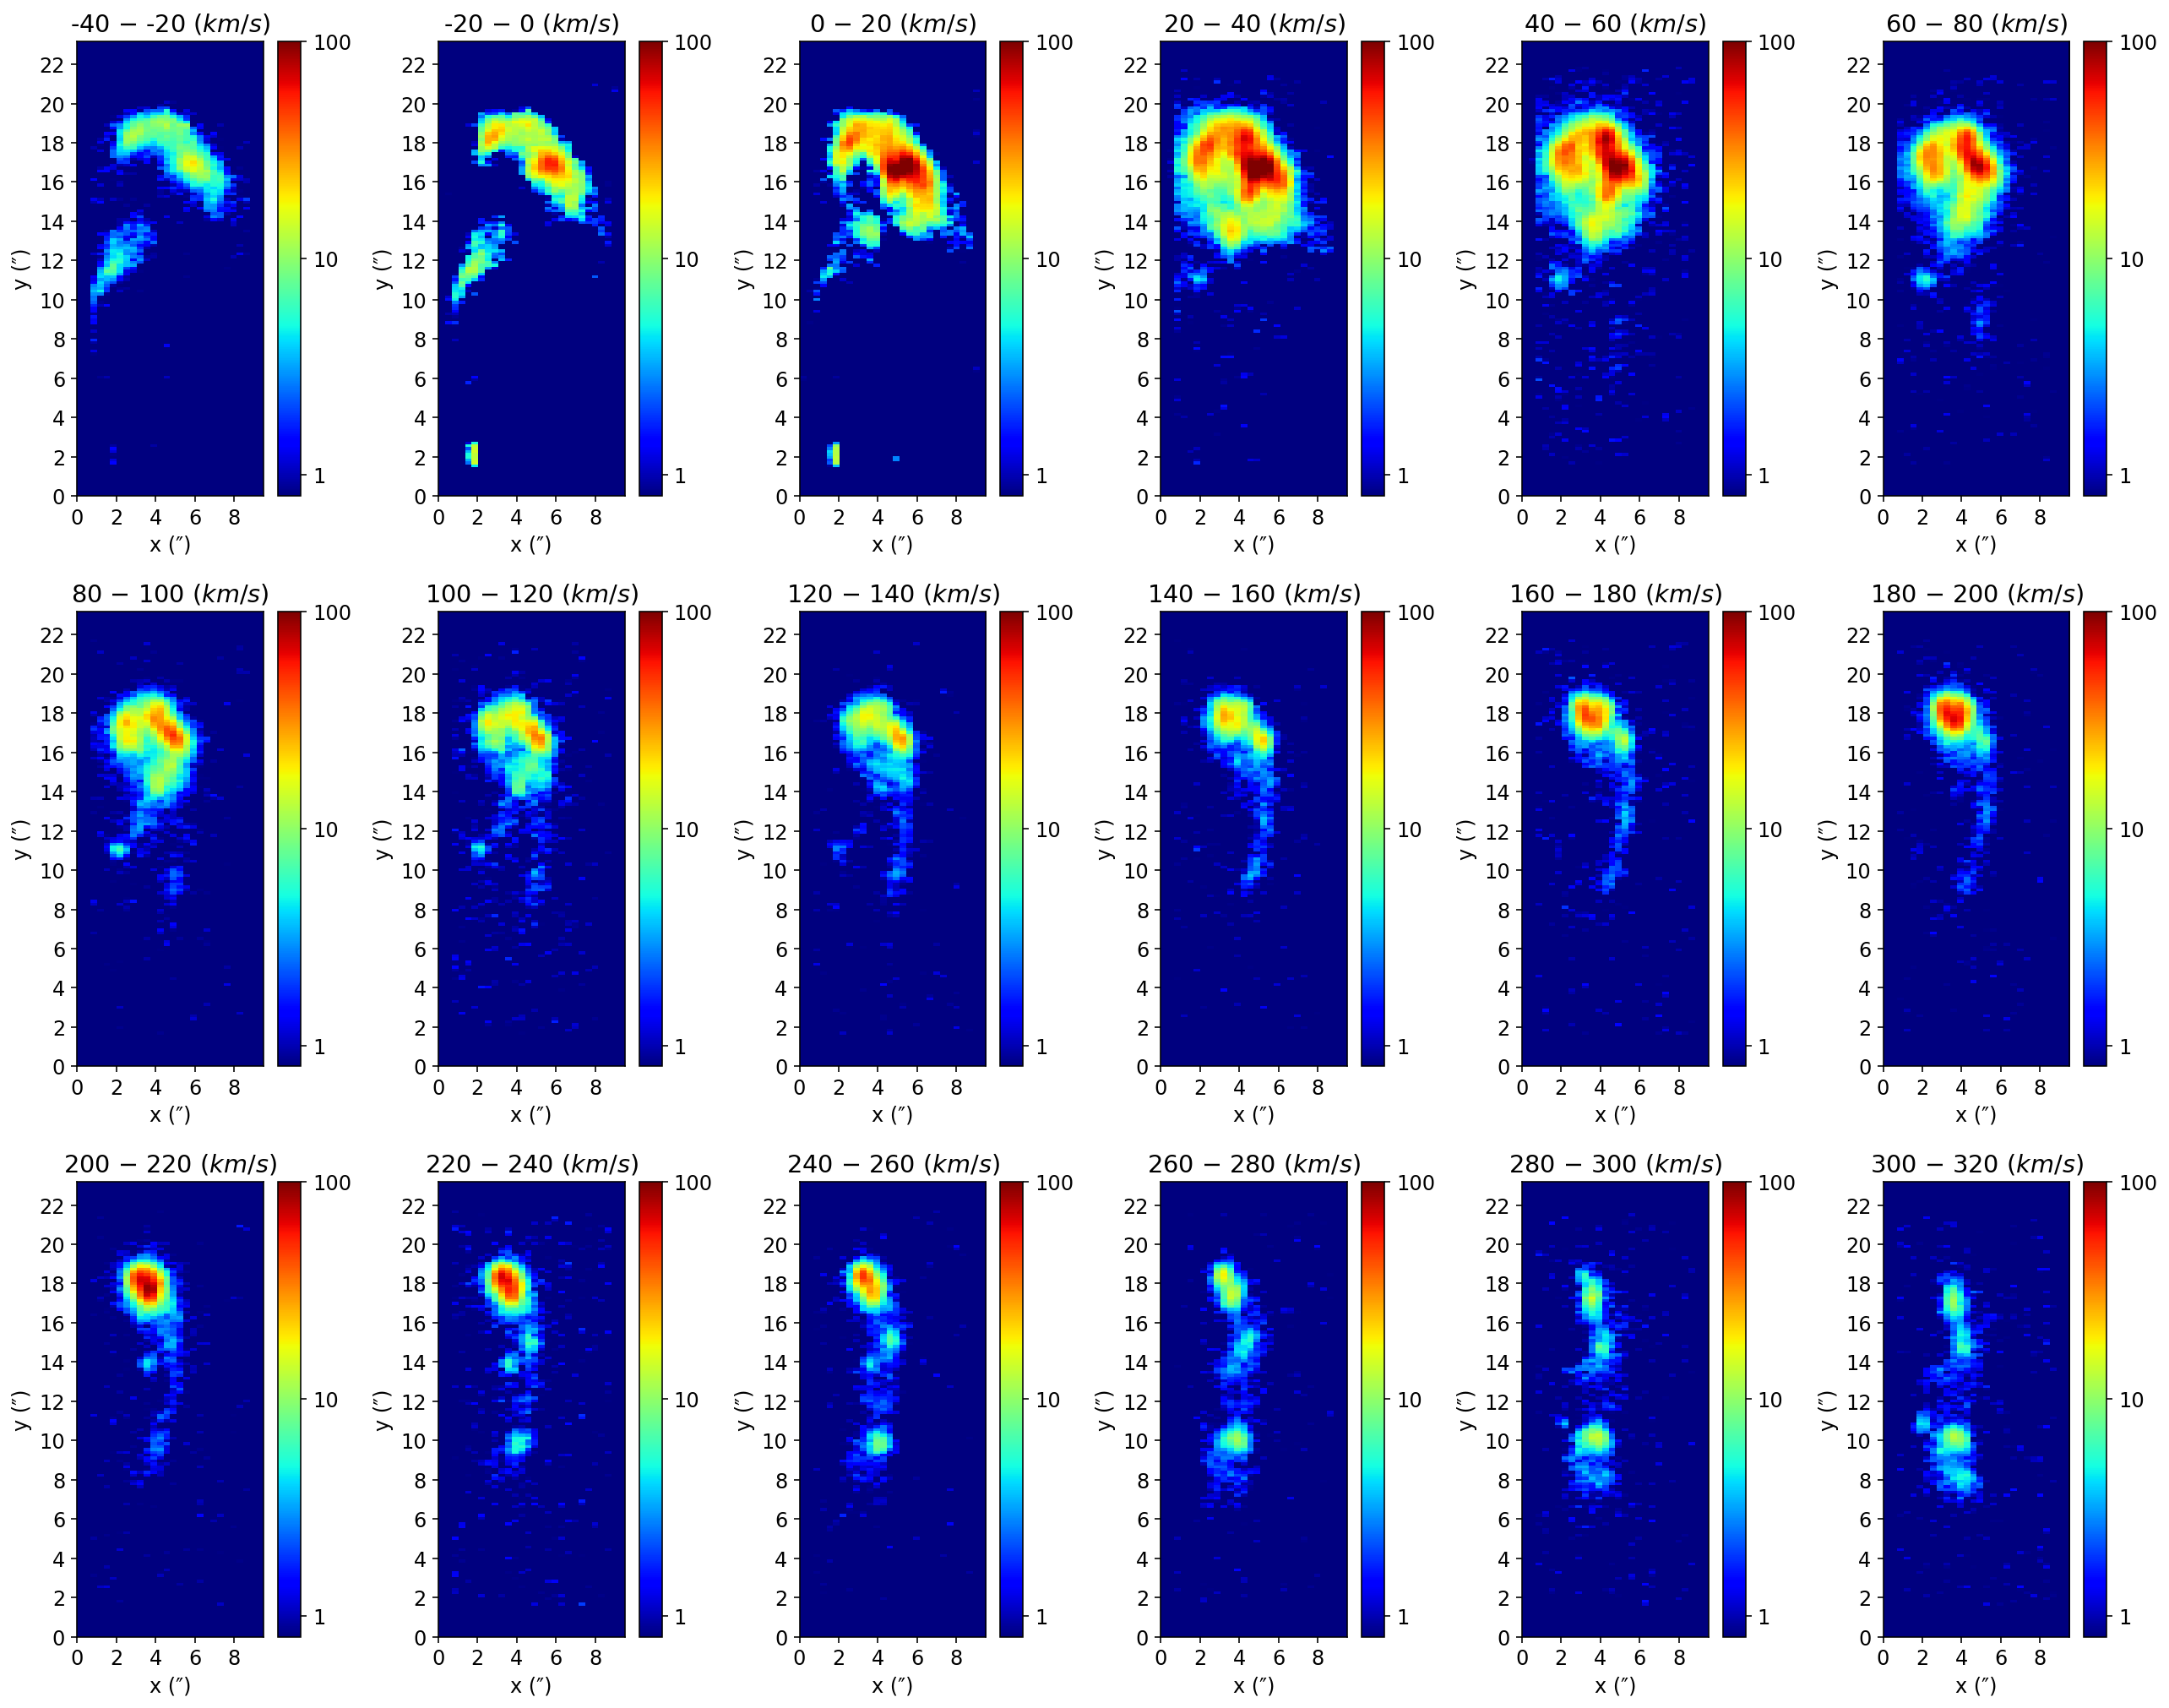

In [78]:
make_bin(-40, 320, 20, "oi", 0.8, 100, 6, (18, 70), [1, 10, 100])

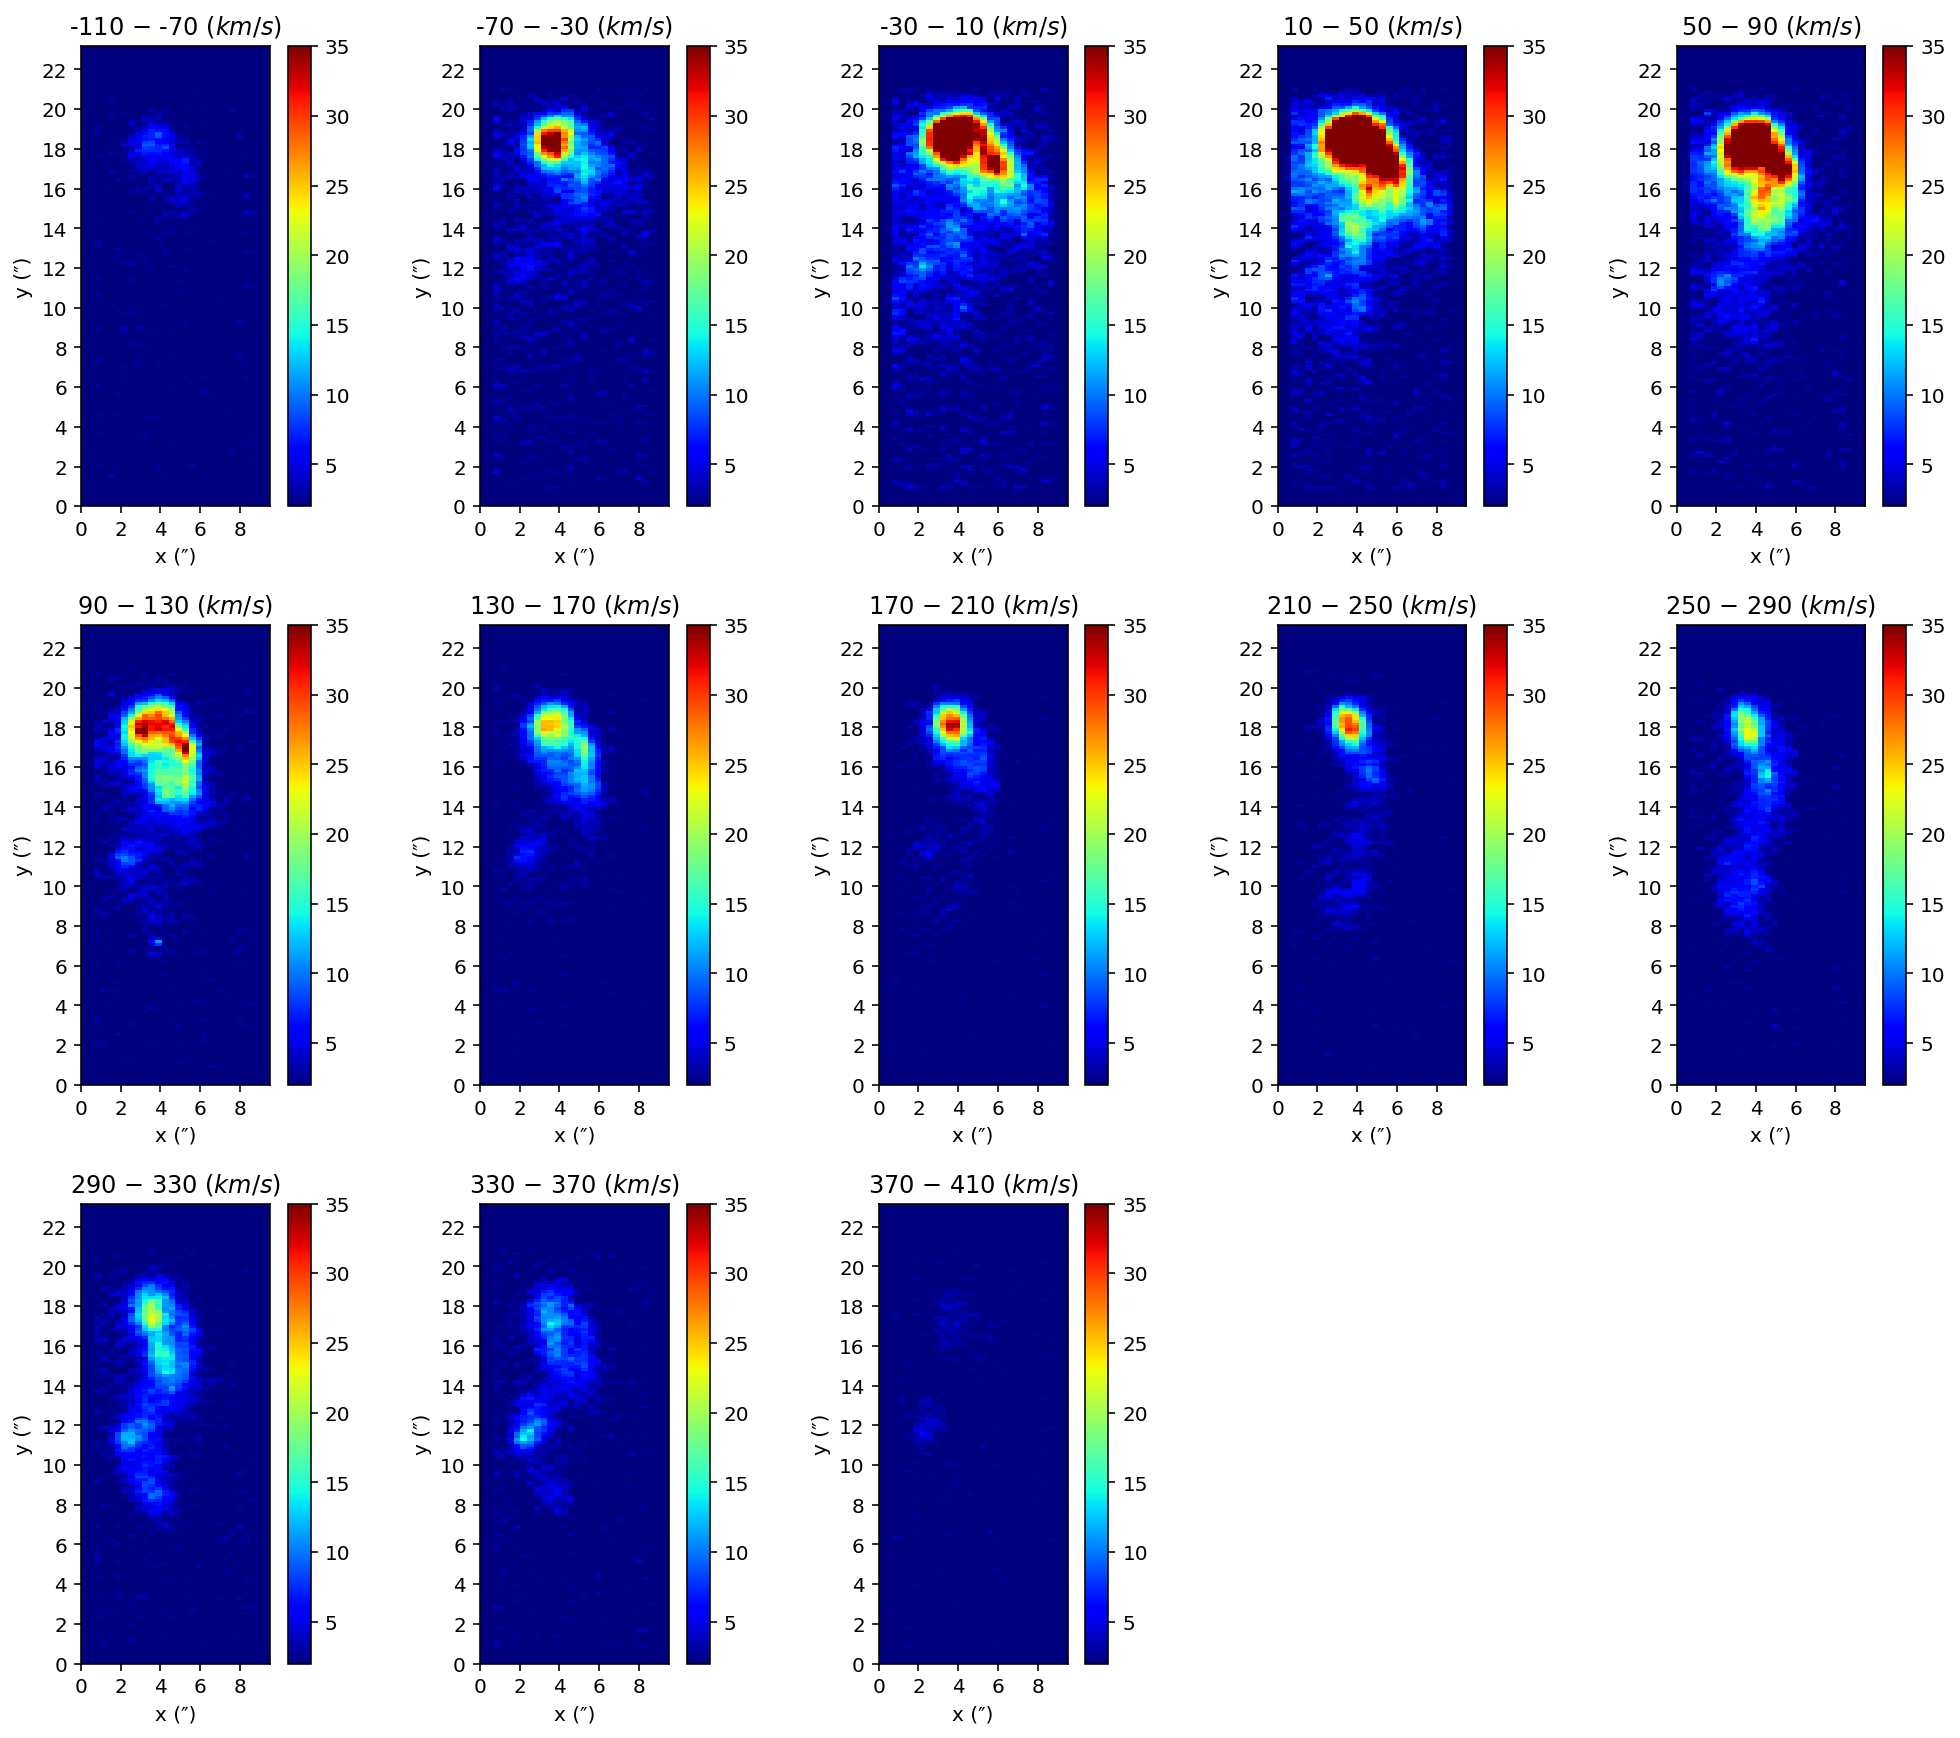

In [85]:
plt.rc('font', size=10)
make_bin(-110, 380, 40, "oii", 2, 35, 5, (14, 60))

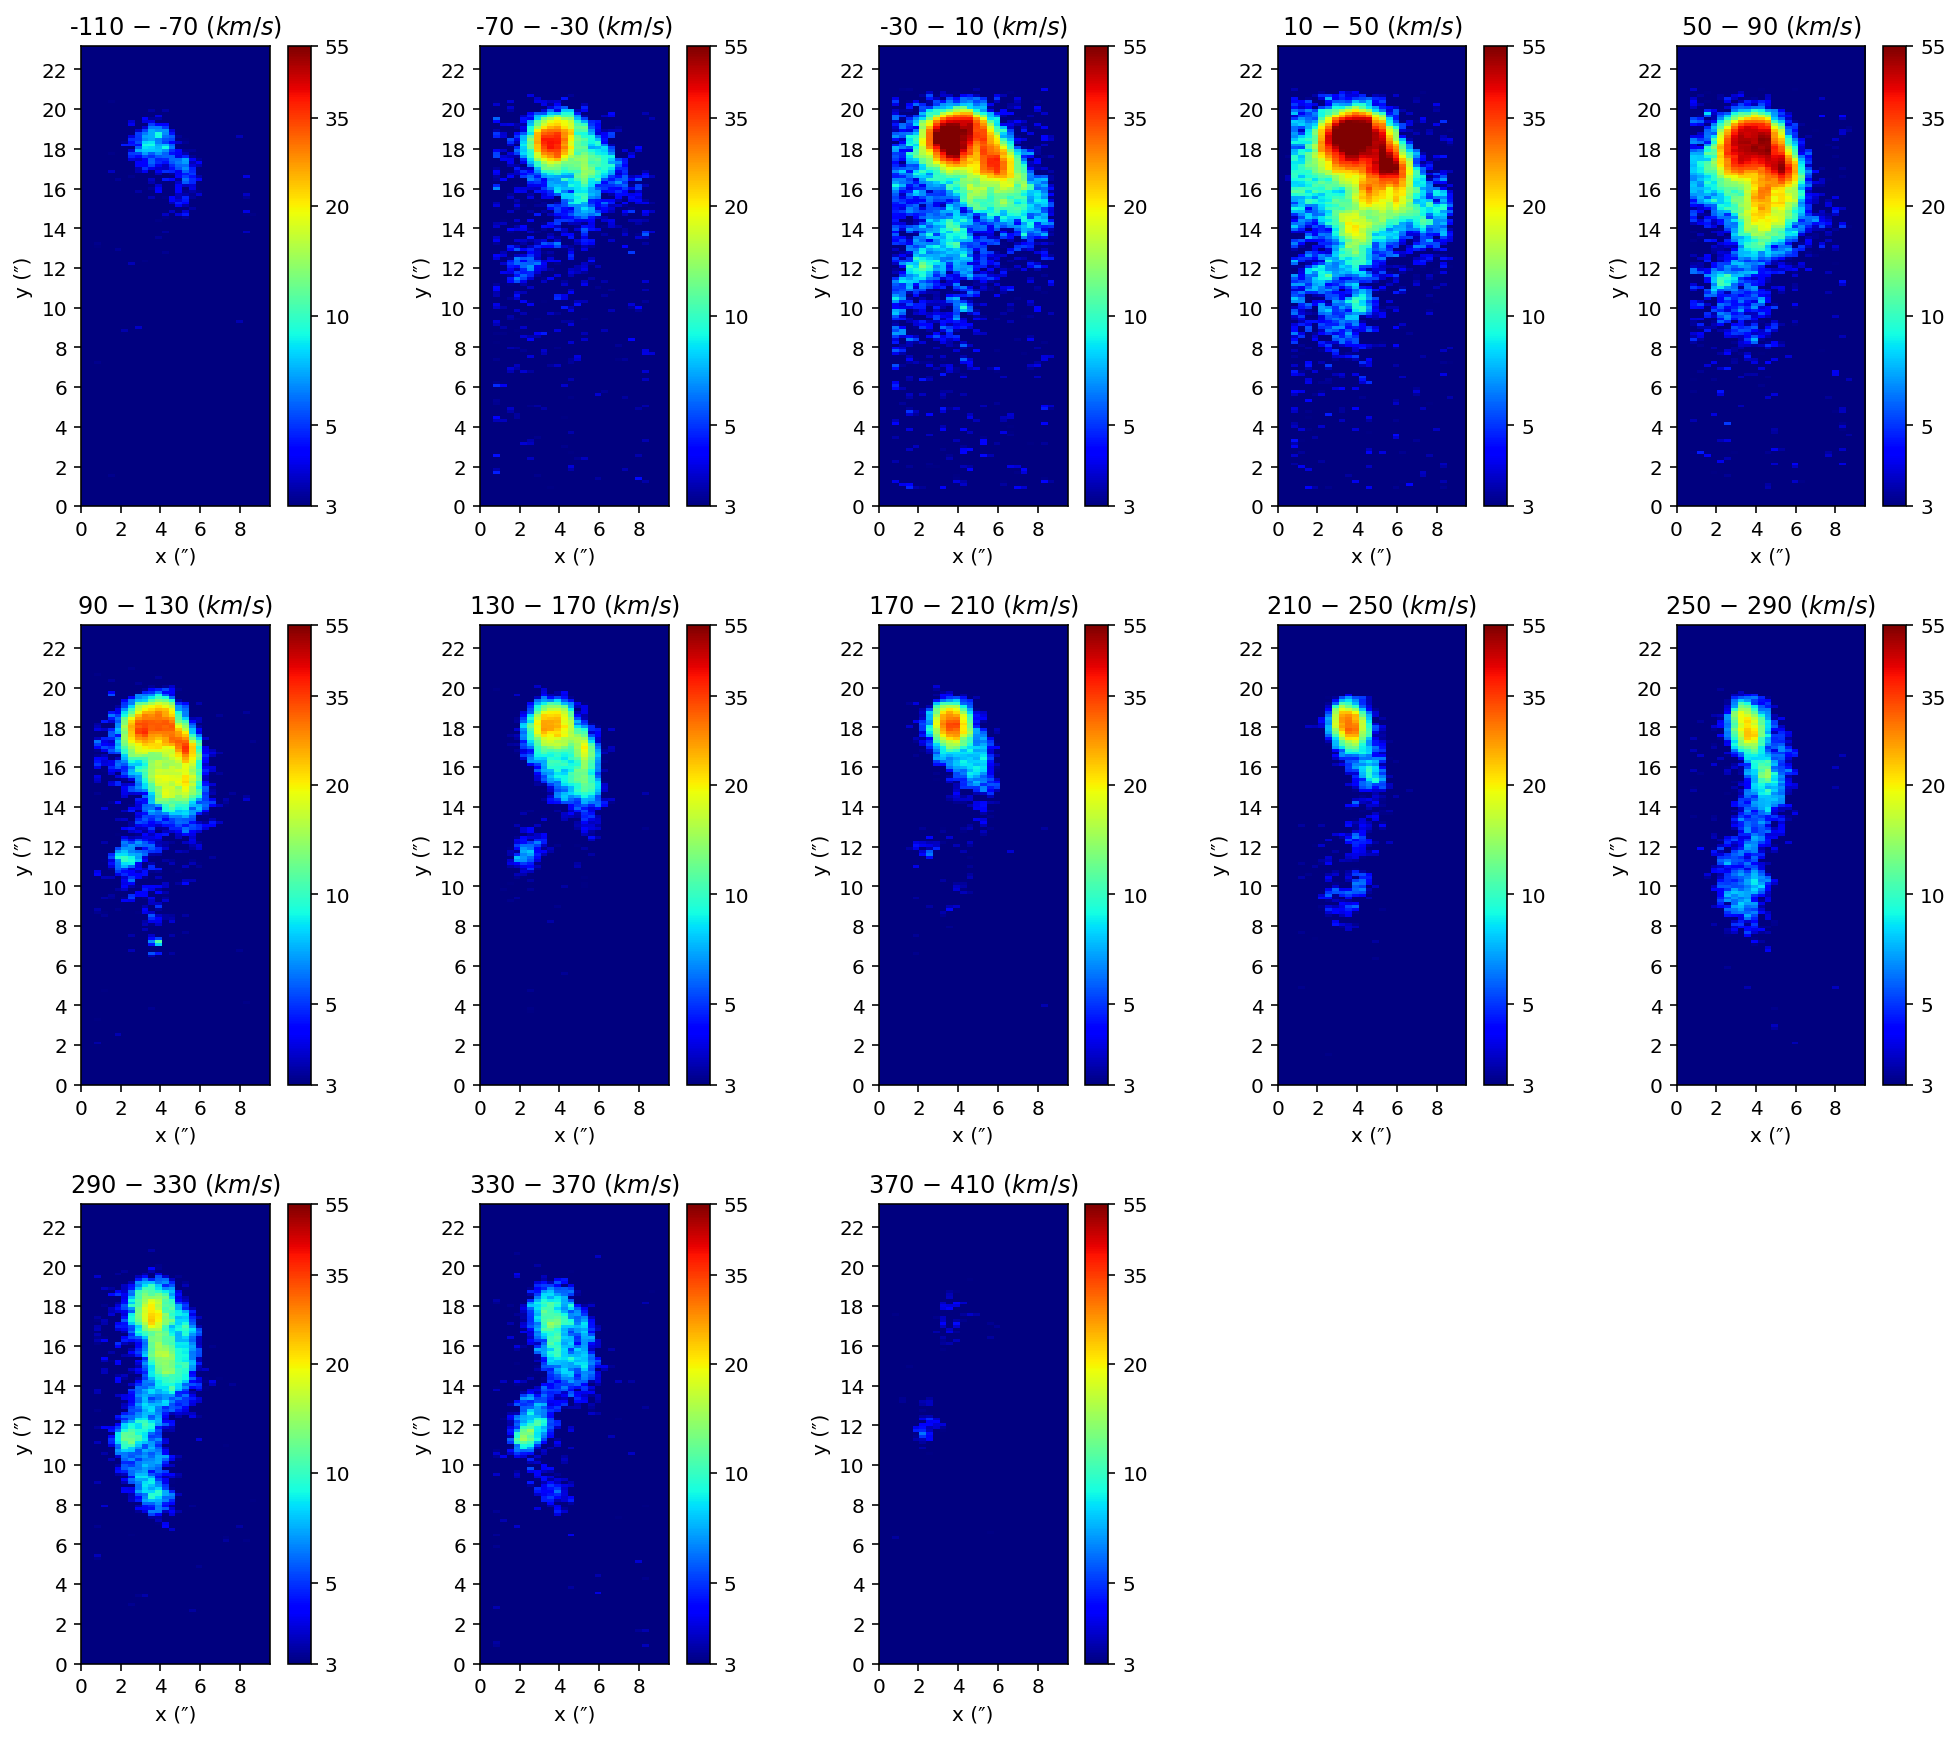

In [103]:
plt.rc('font', size=10)
make_bin(-110, 380, 40, "oii", 3, 55, 5, (14, 60), [3, 5, 10, 20, 35, 55])

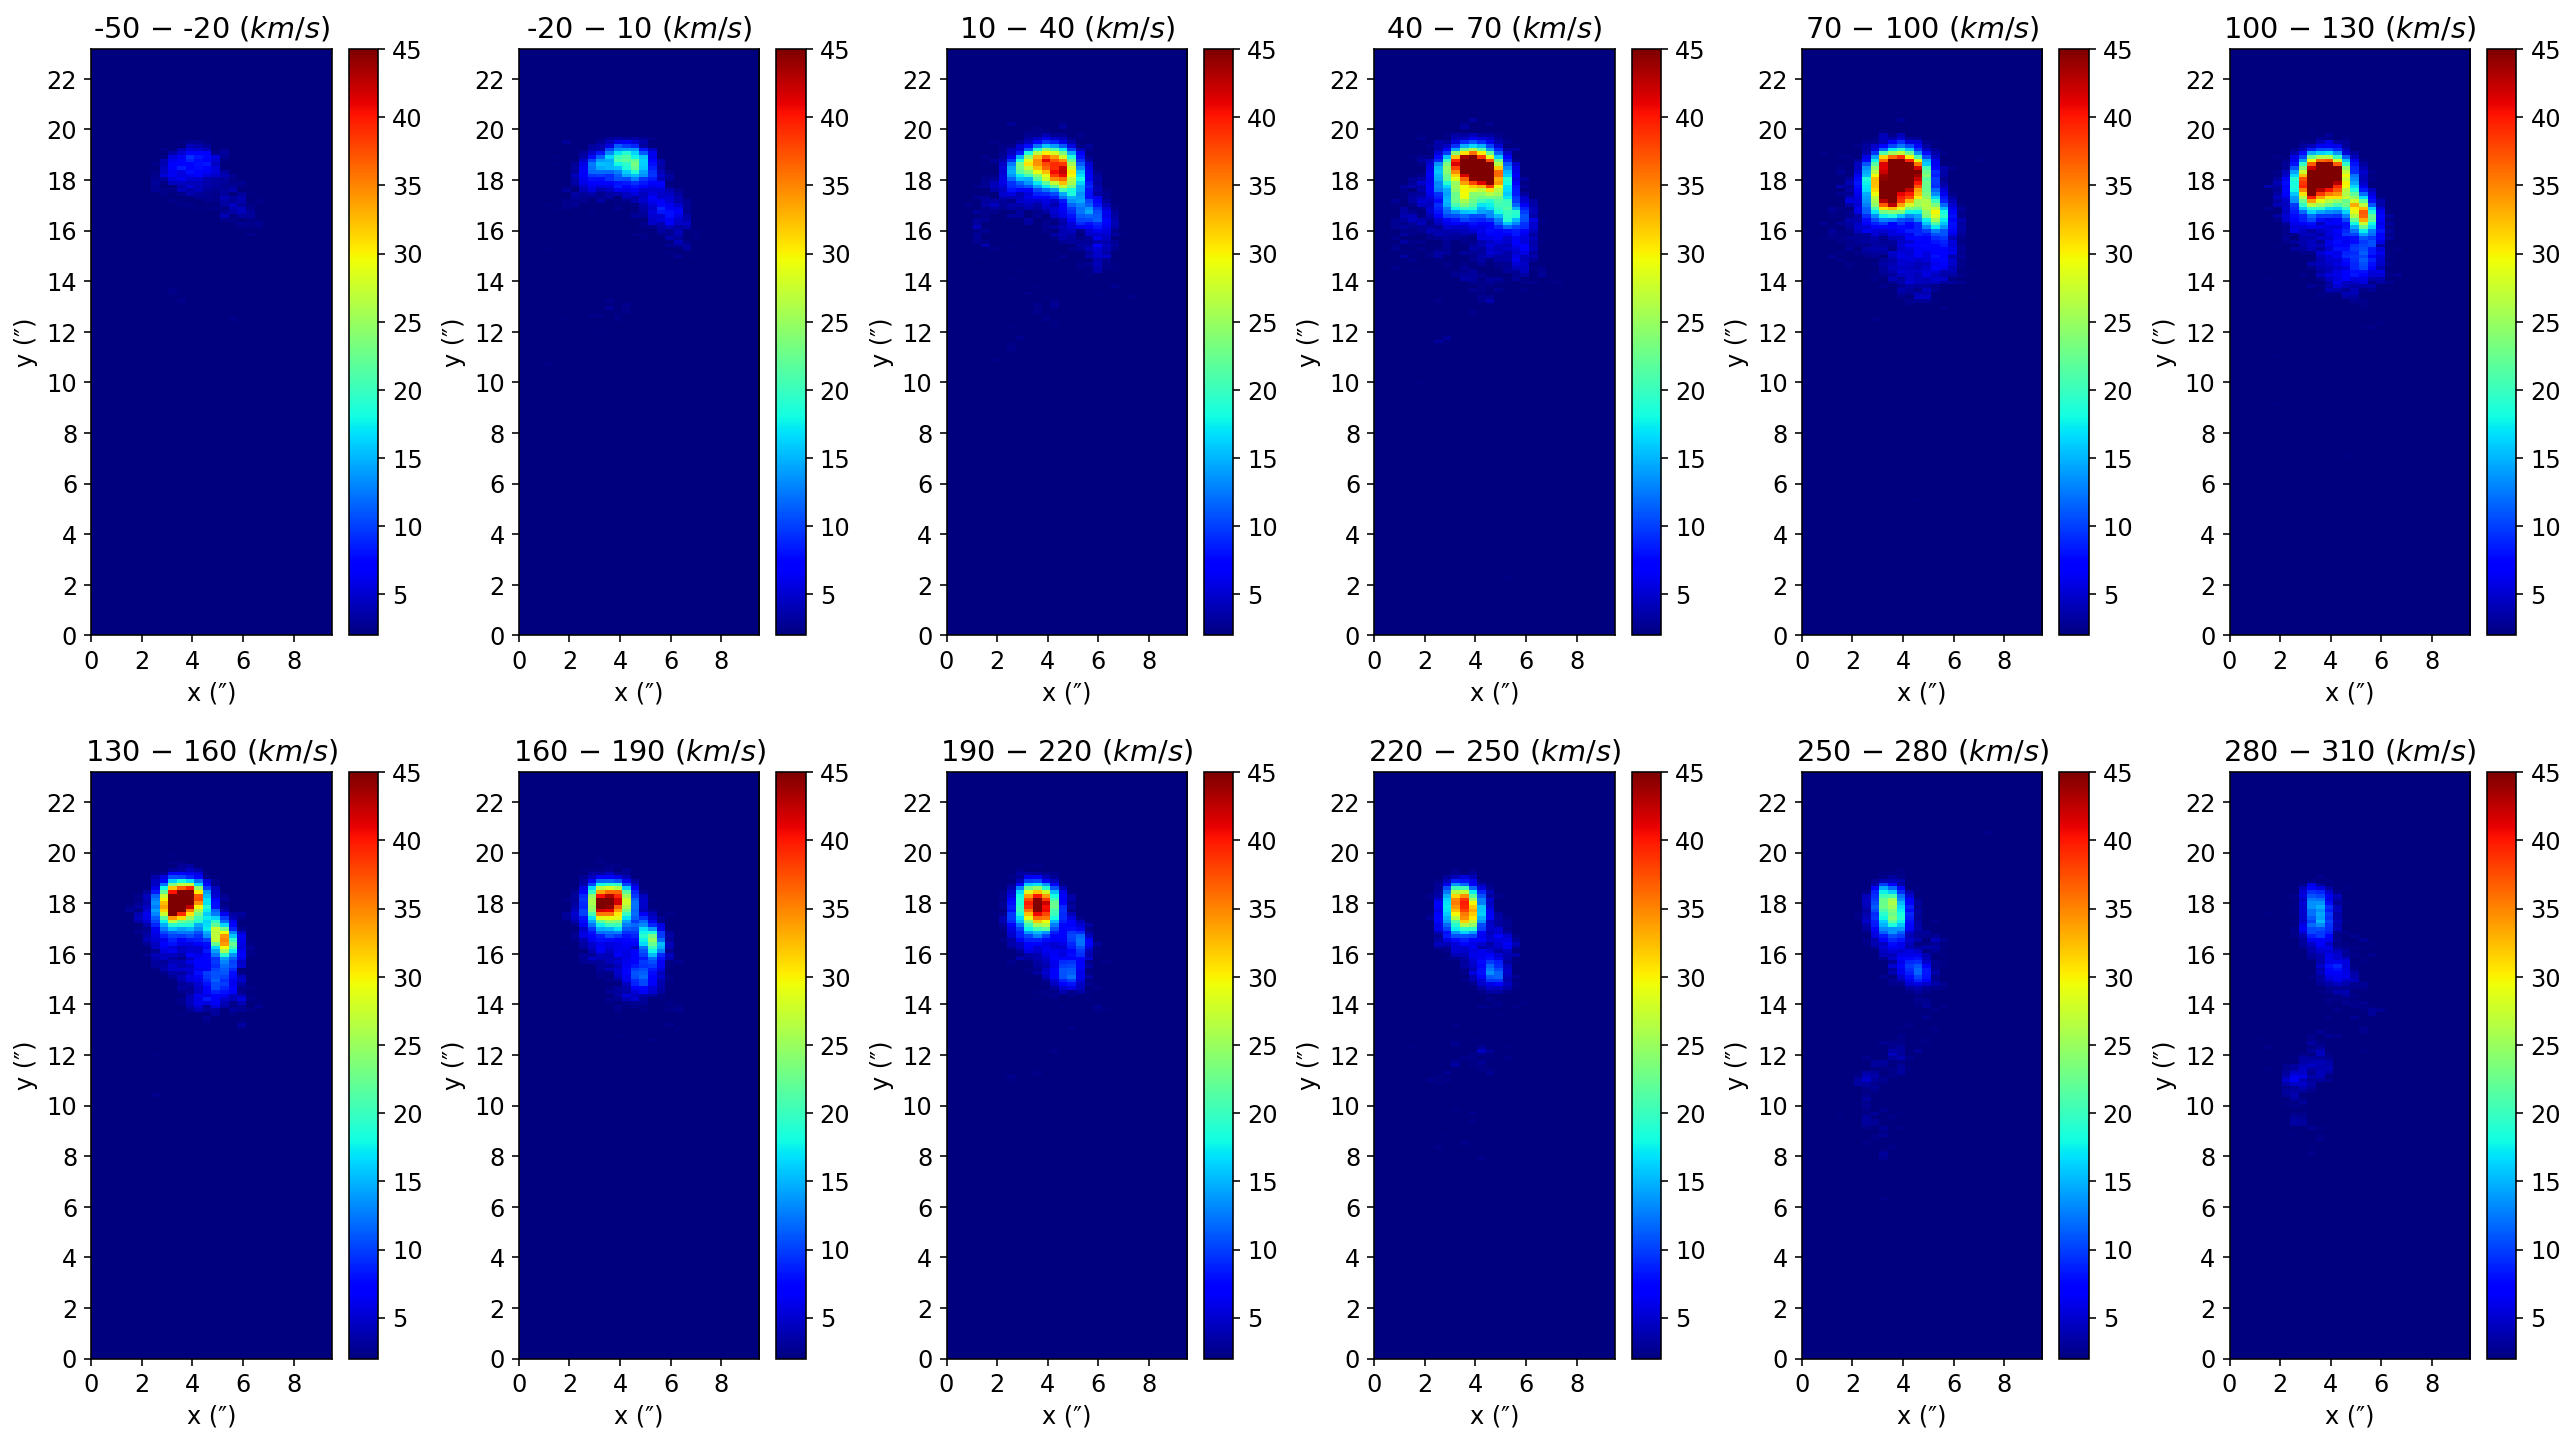

In [112]:
plt.rc('font', size=12)
make_bin(-50, 310, 30, "oiii", 2, 45, 6, (18, 75))

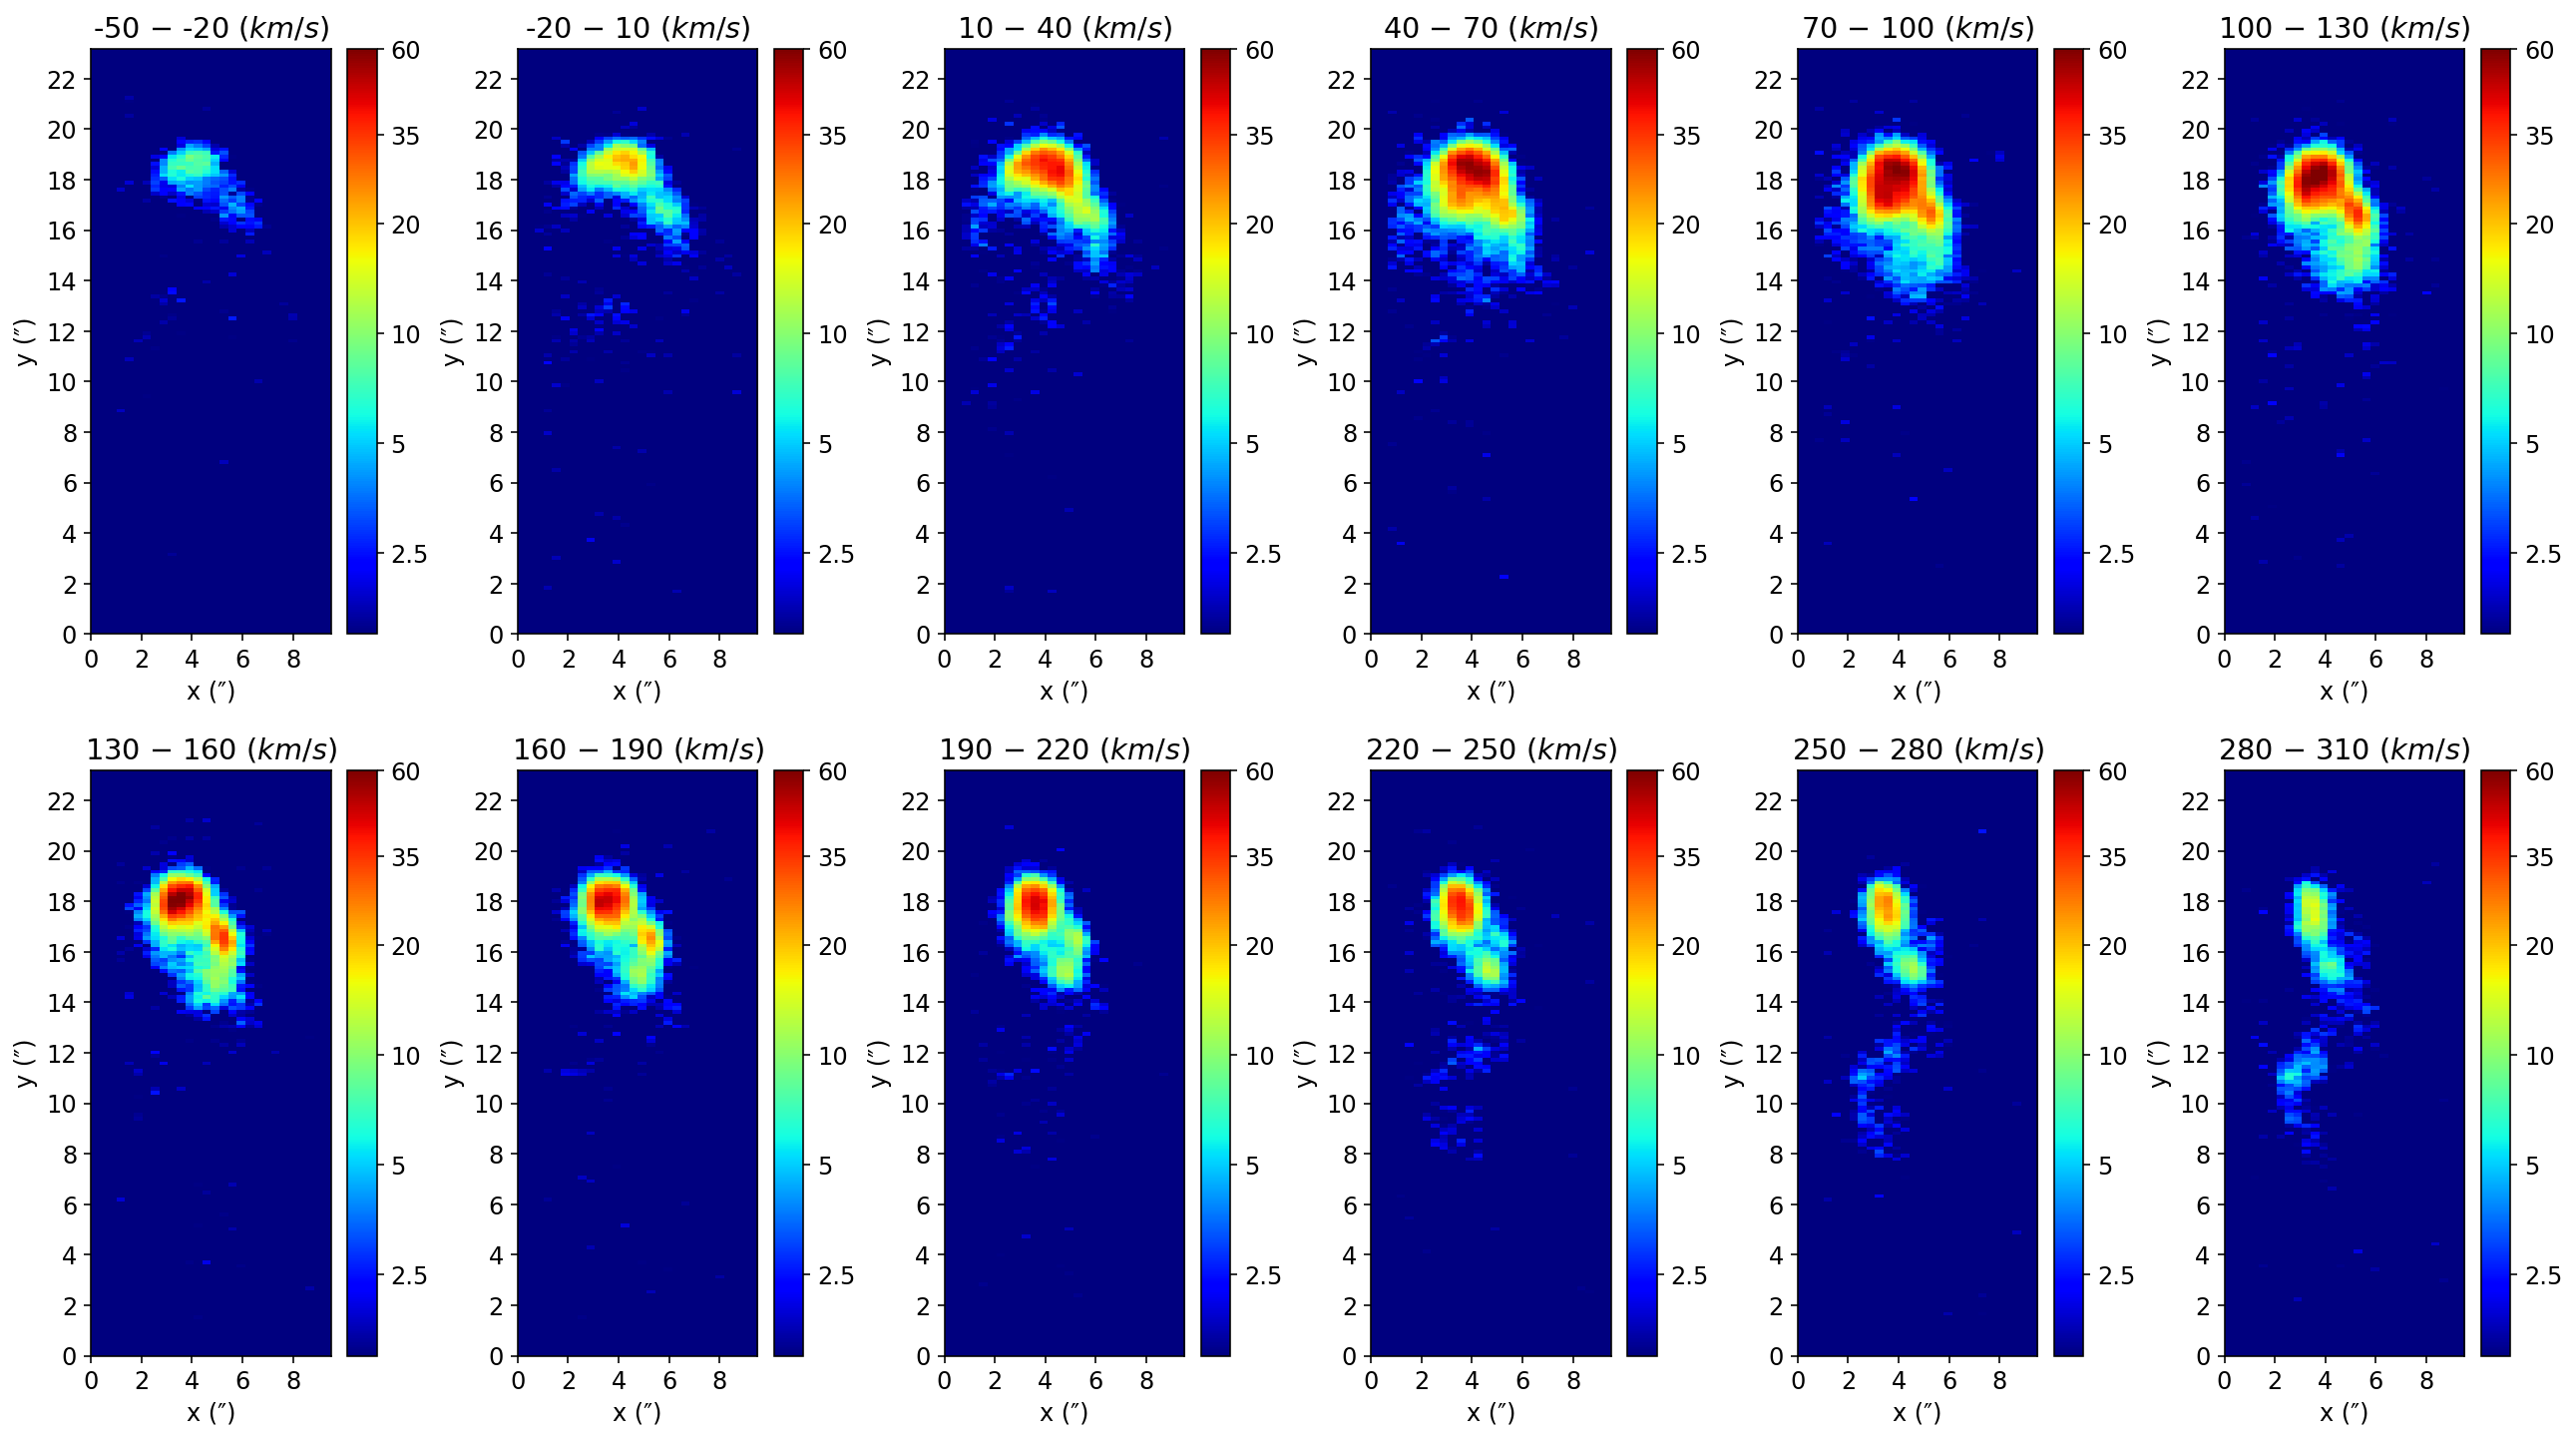

In [122]:
plt.rc('font', size=12)
make_bin(-50, 310, 30, "oiii", 1.5, 60, 6, (18, 75), [2.5, 5, 10, 20, 35, 60])

In [86]:
center = 5006.85
wv_lst = np.arange(5005.75, 5013.50 + 0.5, 0.5)
vel_lst = 299792.458 * ((wv_lst  - center) / center)
vel_lst

array([-65.86410693, -35.92587651,  -5.98764608,  23.95058434,
        53.88881476,  83.82704519, 113.76527561, 143.70350604,
       173.64173646, 203.57996689, 233.51819731, 263.45642773,
       293.39465816, 323.33288858, 353.27111901, 383.20934943,
       413.14757986])

In [87]:
vel_lst[0] - vel_lst[1]

-29.938230424318675

In [88]:
vel_lst[-1] - vel_lst[-2]

29.938230424318647

In [24]:
299792.458 * ((6229.5  - 6300.31) / 6300.31)

-3369.406259530105